# Notebook 1: Simulator of resistome
In this notebook, we present the functions used to create Figure 2 y 3 in the article **TDA captures HGT in AMR gene families among clinically relevant bacteria**.
## Import libraries

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import gudhi as gd
from scipy.spatial.distance import hamming
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt
import networkx as nx
import plotly.graph_objects as go
import plotly.io as pio



## Define functions
1. `calculate_hamming_matrix` and `calculate_normalized_hamming_matrix`.These functions calculate a Hamming distance matrix from an array where the columns are genes and the rows are genomes.

In [2]:
# Let's assume that "population" is a numpy ndarray with your genomes as rows.
def calculate_hamming_matrix(population):
    # Number of genomes
    num_genomes = population.shape[0]
    # Create an empty matrix for Hamming distances
    hamming_matrix = np.zeros((num_genomes, num_genomes), dtype=int)
   # Calculate the Hamming distance between each pair of genomes
    for i in range(num_genomes):
        for j in range(i+1, num_genomes):  # j=i+1 to avoid calculating the same distance twice
            # The Hamming distance is multiplied by the number of genes to convert it into an absolute distance
            distance = hamming(population[i], population[j]) * num_genes
            hamming_matrix[i, j] = distance
            hamming_matrix[j, i] = distance  # The matrix is symmetric
    
    return hamming_matrix
# Assuming that "population" is a NumPy ndarray with your genomes as rows
def calculate_normalized_hamming_matrix(population):
    num_genomes = population.shape[0]
    num_genes = population.shape[1]
    hamming_matrix = np.zeros((num_genomes, num_genomes), dtype=float)
    
    for i in range(num_genomes):
        for j in range(i+1, num_genomes):  # It's not necessary to calculate when i == j
            # The sum of boolean comparisons will give the total number of differences
            distance = np.sum(population[i] != population[j]) / num_genes
            hamming_matrix[i, j] = distance
            hamming_matrix[j, i] = distance  # Taking advantage of symmetry
    
    return hamming_matrix



2. The `create_complex` function generates a 3-dimensional Rips simplicial complex and computes persistent homology from a distance matrix.

In [3]:
def create_complex(distance_matrix):
    # Create the Rips simplicial complex from the distance matrix
    rips_complex = gd.RipsComplex(distance_matrix=distance_matrix)
    # Create the simplex tree from the Rips complex with a maximum dimension of 3
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=3)
    # Compute the persistence of the simplicial complex
    persistence = simplex_tree.persistence()
    # Return the persistence diagram or barcode
    return persistence, simplex_tree


3. The `plot_dendrogram` function creates a dendrogram from a population of genomes.

In [4]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

def plot_dendrogram(data, path=None):
    """Plot a dendrogram from the data and optionally save it to a file."""
    linked = linkage(data, 'single')
    dendrogram(linked, orientation='top', distance_sort='descending')
    
    # Ajustar el tamaño de la fuente para los ejes
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    # Ajustar el grosor de las líneas del dendrograma
    # plt.gca().spines.values() # Este comando no ajusta el grosor, solo obtiene los ejes

    # Guardar la figura si se proporciona una ruta
    if path:
        plt.savefig(path, bbox_inches='tight')

    plt.show()

4. The `visualize_simplicial_complex` function creates a graphical representation of a simplicial complex for a given filtration level, based on a simplex tree.

In [5]:


def visualize_simplicial_complex(simplex_tree, filtration_value, vertex_names=None, save_filename=None, plot_size=1, dpi=600):
    G = nx.Graph()
    triangles = []
    color_map = plt.get_cmap('coolwarm')

    # Create a dictionary to map simplices to colors based on their filtration values
    simplex_colors = {}
    max_filtration = max(filt for _, filt in simplex_tree.get_filtration() if filt <= filtration_value)

    for simplex, filt in simplex_tree.get_filtration():
        if filt <= filtration_value:
            # Normalize the filtration value and get the corresponding color
            normalized_value = filt / max_filtration
            color = color_map(normalized_value)
            rgba_color = 'rgba({}, {}, {}, {})'.format(int(color[0]*255), int(color[1]*255), int(color[2]*255), color[3])
            simplex_colors[tuple(simplex)] = rgba_color

            # Add nodes and edges/triangles to the graph
            if len(simplex) == 2:
                G.add_edge(simplex[0], simplex[1])
            elif len(simplex) == 1:
                G.add_node(simplex[0])
            elif len(simplex) == 3:
                triangles.append(simplex)

    # Position nodes using NetworkX's spring layout
    pos = nx.spring_layout(G)

    # Node trace
    x_values = [pos[key][0] for key in pos]
    y_values = [pos[key][1] for key in pos]
    node_labels = [vertex_names[node] if vertex_names else node for node in pos]
    #node_trace = go.Scatter(x=x_values, y=y_values, mode='markers+text', hoverinfo="text", marker=dict(size=10), text=node_labels, textposition='top center')
    node_trace = go.Scatter(x=x_values, y=y_values, mode='markers+text', hoverinfo="text",marker=dict(size=14), text=node_labels, textposition='top center', textfont=dict(size=14))

    
    # Edge traces
    edge_traces = []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        color = simplex_colors.get(edge, 'rgba(0, 0, 0, 0.5)')  # Default color if edge not in simplex_colors
        edge_trace = go.Scatter(x=[x0, x1, None], y=[y0, y1, None], mode='lines', line=dict(width=3, color=color))
        edge_traces.append(edge_trace)

        # Triangle traces
    triangle_traces = []
    for triangle in triangles:
        x0, y0 = pos[triangle[0]]
        x1, y1 = pos[triangle[1]]
        x2, y2 = pos[triangle[2]]
    # Utilizando el nuevo color RGBA para los triángulos
        color = 'rgba(244, 157, 126, 0.545)'  # Color #F49D7E en formato RGBA
        triangle_trace = go.Scatter(x=[x0, x1, x2, x0, None], y=[y0, y1, y2, y0, None], fill='toself', mode='lines', line=dict(width=3), fillcolor=color)
        triangle_traces.append(triangle_trace)

    # Combine all traces and create the figure

    layout = go.Layout(showlegend=False, hovermode='closest', xaxis=dict(showgrid=False, zeroline=False,tickfont=dict(size=16, family='Arial, sans-serif') ), yaxis=dict(showgrid=False, zeroline=False,tickfont=dict(size=16, family='Arial, sans-serif')))

    fig = go.Figure(data=edge_traces + triangle_traces + [node_trace], layout=layout)

    # Set the figure size
    fig.update_layout(width=plot_size * dpi, height=plot_size * dpi)

    # Save the figure if a filename is provided
    if save_filename:
        pio.write_image(fig, save_filename, width=plot_size * dpi, height=plot_size * dpi, scale=1)

    # Show the figure
    fig.show()

    return G


### Population simulator with horizontal inheritance

5. The `mutate` function receives a genome, a list of 1s and 0s, where a 1 indicates the presence of that gene in the genome and a 0 indicates its absence. This function also uses the probability of mutation at each position. Ultimately, it returns a genome with some mutations and the positions where these mutations occurred.
6. The `create_generation` function generates a new population from an existing one, using `num_offspring` to determine the number of offspring for each genome in the initial population.
7. The `create_population` function generates a population with vertical inheritance, with parameters for the number of generations, mutation probability, and number of genes.


In [6]:
import numpy as np

def mutate(genome, prob, mutated_positions):
    """Performs mutations on a genome with a certain probability."""
    mutations = []
    for i in range(len(genome)):
        if not mutated_positions[i] and np.random.rand() < prob:
            genome[i] = 1 if genome[i] == 0 else 0
            mutations.append(i)
            mutated_positions[i] = True
    return genome, mutations

def create_generation(population, num_offspring, prob, mutated_positions):
    """Creates a new generation from the existing population."""
    new_population = []
    new_generation_history = []
    for idx, genome in enumerate(population):
        for _ in range(num_offspring):
            new_genome, mutations = mutate(genome.copy(), prob, mutated_positions)
            new_population.append(new_genome)
            new_generation_history.append({'parent': idx, 'mutations': mutations})
    return new_population, new_generation_history

def create_population(num_genes, mutation_probability, num_generations, num_offspring, percentage_ones,semilla):
    np.random.seed(semilla)

    initial_genome = np.random.choice([0, 1], size=num_genes, p=[1-percentage_ones, percentage_ones])
    population = [initial_genome]
    genome_history = []
    global_mutated_positions = np.zeros(num_genes, dtype=bool)

    for generation in range(num_generations):
        population, generation_history = create_generation(population, num_offspring, mutation_probability, global_mutated_positions)
        genome_history.extend(generation_history)
        print(f"Generation {generation+1}: {len(population)} genomes")
        # Uncomment the next line if you want to see the details of each generation
        # print(len(population), generation_history)

    return population, genome_history



In [86]:
def plot_persistence_barcode(persistence, max_filtration_value, save_path=None):
    """
    Plots the persistence barcode from the given persistence diagram.

    Parameters:
    - persistence: Output from simplex_tree.persistence(), a list of tuples where the first element is the homology
                   dimension (e.g., 0 for connected components, 1 for loops, etc.) and the second element is a tuple
                   representing (birth, death) of the feature.
    - max_filtration_value: The maximum filtration value to display on the x-axis.
    - save_path: If provided, saves the plot to the specified file path.

    Returns:
    - None
    """
    fig, ax = plt.subplots(figsize=(6, 6))

    # Filter the bars for Betti 0 (connected components) and Betti 1 (1-holes)
    bars_betti_0 = [(i[1][0], i[1][1]) for i in persistence if i[0] == 0]
    bars_betti_1 = [(i[1][0], i[1][1]) for i in persistence if i[0] == 1]

    # Plot the blue bars for Betti 1 (1-holes)
    for i, (birth, death) in enumerate(bars_betti_1):
        death = min(death, max_filtration_value)  # Cap death at max_filtration_value
        ax.plot([birth, death], [i, i], color='blue', lw=3, label=r"$\beta_1$ (1-holes)" if i == 0 else "")

    # Plot the green bars for Betti 0 (connected components)
    offset = len(bars_betti_1)
    for i, (birth, death) in enumerate(bars_betti_0):
        death = min(death, max_filtration_value)  # Cap death at max_filtration_value
        ax.plot([birth, death], [i + offset, i + offset], color='green', lw=1.5, label=r"$\beta_0$ (connected components)" if i == 0 else "")

    # Add title and labels
    ax.set_title(f"Persistent Homology Barcode")
    ax.set_xlabel("Filtration value")
    ax.set_yticks([])
    ax.set_xlim(0, max_filtration_value)  # Adjust x-axis to maximum filtration value
    ax.grid(True)

    # Add legend
    ax.legend()

    # Save the plot if save_path is provided
    if save_path:
        plt.tight_layout()
        plt.savefig(save_path, dpi=300)

    # Display the plot
    plt.show()

We generate a population with 128 genomes with vertical inheritance using the following parameters.

In [7]:
# Example usage
num_genes = 505
mutation_probability = 1 / num_genes
num_generations = 7
num_offspring = 2
percentage_ones = 0.25

population, population_genome_history = create_population(num_genes, mutation_probability, num_generations, num_offspring, percentage_ones,42)


Generation 1: 2 genomes
Generation 2: 4 genomes
Generation 3: 8 genomes
Generation 4: 16 genomes
Generation 5: 32 genomes
Generation 6: 64 genomes
Generation 7: 128 genomes


In [8]:
# Calculate the Hamming distance matrix
population = np.array(population)
hamming_distance_matrix = calculate_hamming_matrix(population)

In [38]:
population.shape

(128, 505)

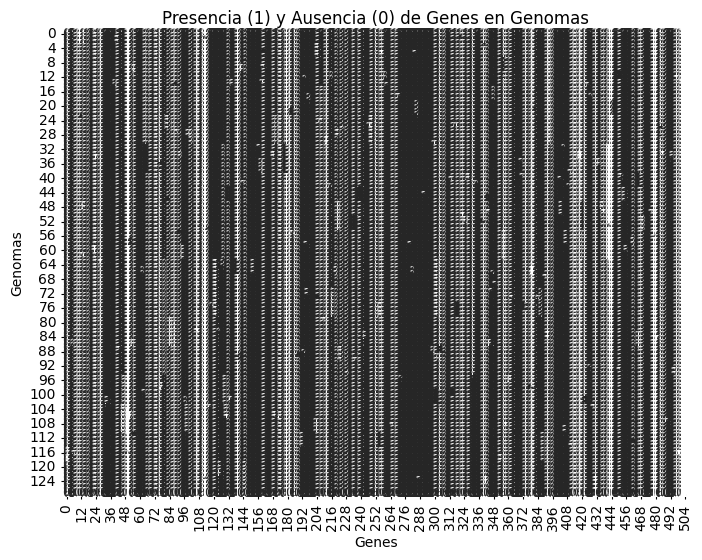

In [39]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Ejemplo de array (1: tiene el gen, 0: no tiene el gen)
# Cada fila es un genoma y cada columna es un gen
array = population
# Crear un heatmap de los datos
plt.figure(figsize=(8, 6))
sns.heatmap(array, cmap="Blues", annot=True, cbar=False, linewidths=0.5)
plt.title('Presencia (1) y Ausencia (0) de Genes en Genomas')
plt.xlabel('Genes')
plt.ylabel('Genomas')
plt.show()

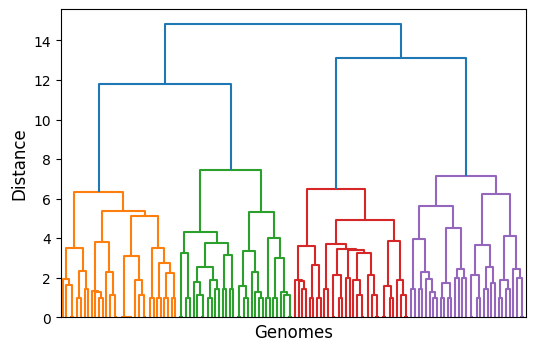

In [72]:
from scipy.cluster.hierarchy import linkage, dendrogram

# Crear el linkage jerárquico con base en las filas (genomas)
Z = linkage(array, method='ward')

# Generar el dendrograma
plt.figure(figsize=(6, 4))
dendrogram(Z)
#plt.title('Dendrograma de Genomas Basado en la Presencia de Genes')
# Ajustar las etiquetas del eje X con un tamaño de fuente personalizado
plt.xticks([])
#plt.xticks(fontsize=2)  # Cambia el valor de fontsize según tu preferencia
plt.yticks(fontsize=10)  # Cambia el tamaño de las etiquetas del eje Y si lo necesitas

#plt.title('Dendrograma de Genomas Basado en la Presencia de Genes')
plt.xlabel('Genomes', fontsize=12)  # Cambia el tamaño de la etiqueta del eje X
plt.ylabel('Distance', fontsize=12)  # Cambia el tamaño de la etiqueta del eje Y
# Guardar la imagen en un archivo con 300 dpi
plt.savefig('plots/dendro_sim128.svg', dpi=300)
plt.show()


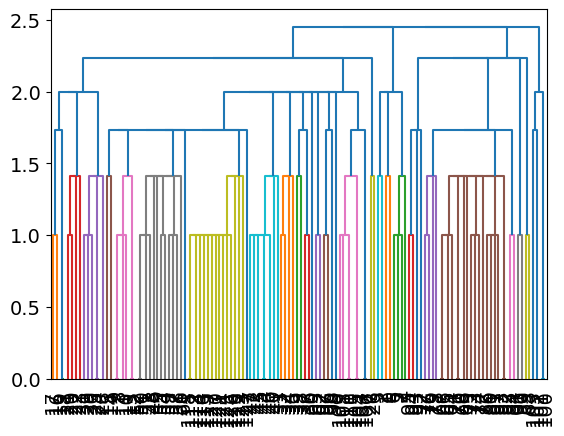

In [10]:
# population now has the changes applied to two randomly selected genomes
plot_dendrogram(population)

usetex mode requires dvipng.


[(0, (0.0, inf)),
 (0, (0.0, 6.0)),
 (0, (0.0, 6.0)),
 (0, (0.0, 6.0)),
 (0, (0.0, 5.0)),
 (0, (0.0, 5.0)),
 (0, (0.0, 5.0)),
 (0, (0.0, 5.0)),
 (0, (0.0, 5.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 2.0)),
 (0, (0.0, 2.0)),
 (0, (0.0, 2.0)),
 (0, (0.0, 2.0)),
 (0, (0.0, 2.0)),
 (0, (0.0, 2.0)),
 (0, (0.0, 2.0)),
 (0, (0.0, 2.0)),
 (0, (0.0, 2.0)),
 (0, (0.0, 2.0)),
 (0, (0.0, 2.0)),
 (0, (0.0, 2.0)),
 (0, (0.0, 2.0)),
 (0, (0.0, 2.0)),
 (0, (0.0, 2.0)),
 (0, (0.0, 2.0)),
 (0, (0.0, 2.0)),
 (0, (0.0, 2.0)),
 (0, (0.0, 2.0)),
 (0, (0.0,

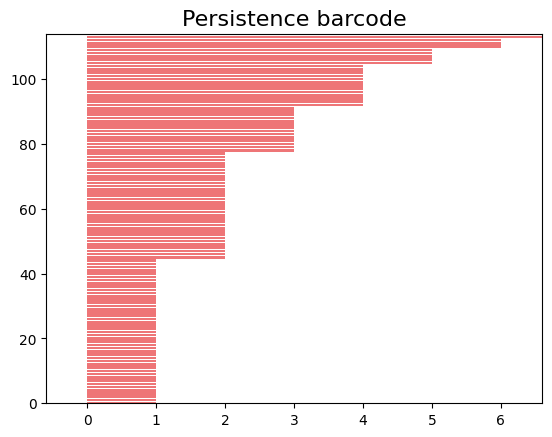

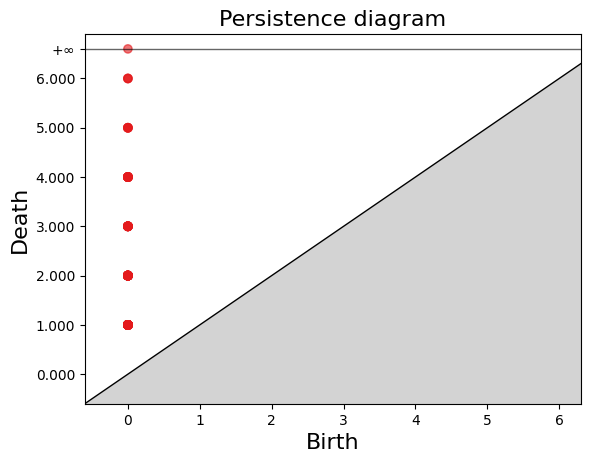

In [11]:


# Create a Vietoris-Rips complex from the distance matrix, and compute persistent homology.
persistence1, simplex_tree1 = create_complex(hamming_distance_matrix)
gd.plot_persistence_barcode(persistence1)
gd.plot_persistence_diagram(persistence1)
persistence1


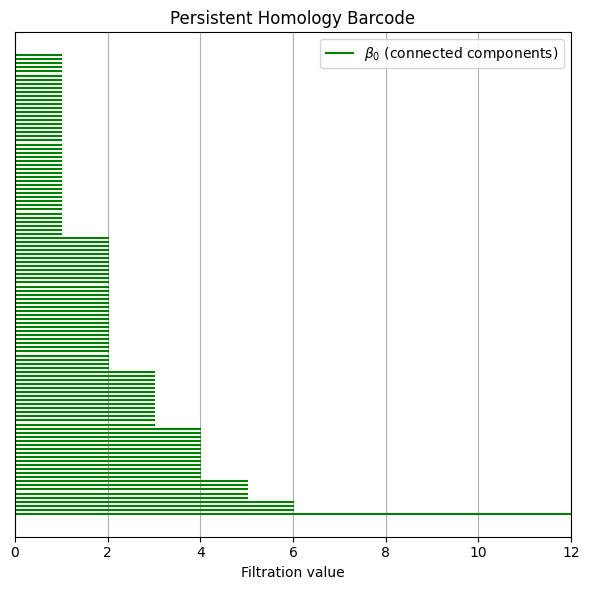

In [83]:
diag = persistence1  # Assuming you have this from GUDHI
plot_persistence_barcode(diag, max_filtration_value=12,save_path="plots/barcode_sim128.svg")

### Horizontal Gene Transfer

In [12]:
def modify_genomes(population, num_groups, group_size, num_positions_to_change):
    np.random.seed(42)  # Puedes usar cualquier número como semilla

    # Crear una copia de la población para evitar modificar el original
    modified_population = population.copy()

    for _ in range(num_groups):
        # Seleccionar genomas de manera aleatoria
        genome_indices = np.random.choice(population.shape[0], group_size, replace=False)
        
        # Elegir un punto de inicio al azar y seleccionar posiciones contiguas para cambiar
        start_position = np.random.choice(population.shape[1] - num_positions_to_change)
        positions_to_change = np.arange(start_position, start_position + num_positions_to_change)
        
        for index in genome_indices:
            # Cambiar los valores en las posiciones seleccionadas a 1
            modified_population[index, positions_to_change] = 1
    
    return modified_population


In [13]:

# Uso de la función
# population = ... (tu matriz de genomas)
# modified_population = modify_genomes(population, num_groups=2, group_size=3, num_positions_to_change=10)

In [14]:
population.shape[1]//32

15

In [15]:
population_2=modify_genomes(population, num_groups=2, group_size=3, num_positions_to_change=population.shape[1]//32)

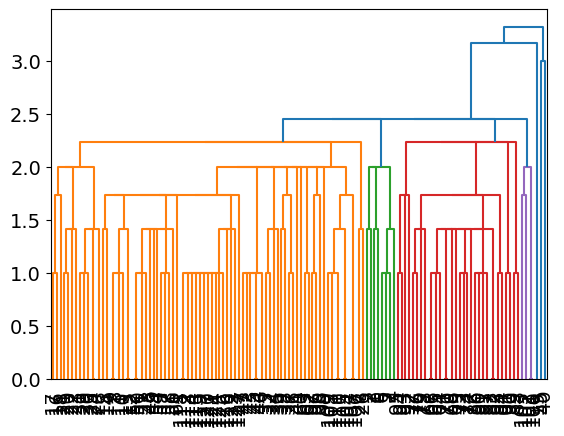

[(1, (11.0, 18.0)),
 (1, (12.0, 16.0)),
 (0, (0.0, inf)),
 (0, (0.0, 11.0)),
 (0, (0.0, 10.0)),
 (0, (0.0, 9.0)),
 (0, (0.0, 6.0)),
 (0, (0.0, 6.0)),
 (0, (0.0, 6.0)),
 (0, (0.0, 5.0)),
 (0, (0.0, 5.0)),
 (0, (0.0, 5.0)),
 (0, (0.0, 5.0)),
 (0, (0.0, 5.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 2.0)),
 (0, (0.0, 2.0)),
 (0, (0.0, 2.0)),
 (0, (0.0, 2.0)),
 (0, (0.0, 2.0)),
 (0, (0.0, 2.0)),
 (0, (0.0, 2.0)),
 (0, (0.0, 2.0)),
 (0, (0.0, 2.0)),
 (0, (0.0, 2.0)),
 (0, (0.0, 2.0)),
 (0, (0.0, 2.0)),
 (0, (0.0, 2.0)),
 (0,

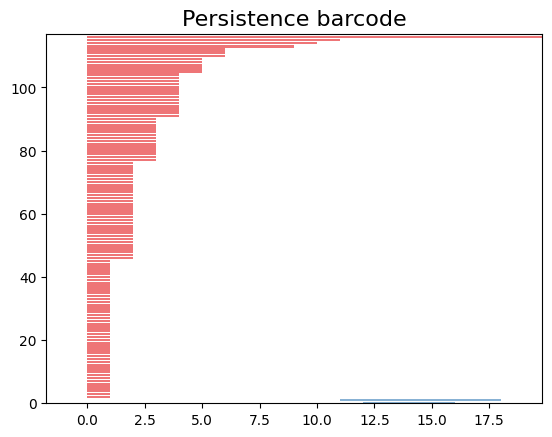

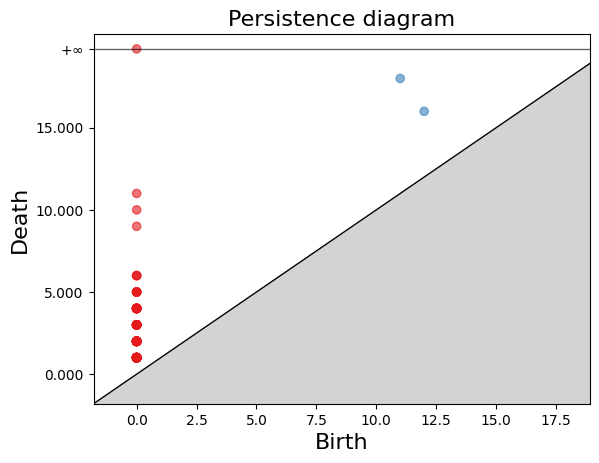

In [16]:
population_2=modify_genomes(population, num_groups=1, group_size=3, num_positions_to_change=population.shape[1]//32)
plot_dendrogram(population_2)
hamming_matrix_2 = calculate_hamming_matrix(population_2)
#hamming_matrix_2

# Print the normalized Hamming distance matrix
#print("Normalized Hamming Distance Matrix:")
#print(normalized_hamming_matrix_2)
persistence2, simplex_tree2 = create_complex(hamming_matrix_2)
gd.plot_persistence_barcode(persistence2)
gd.plot_persistence_diagram(persistence2)
persistence2

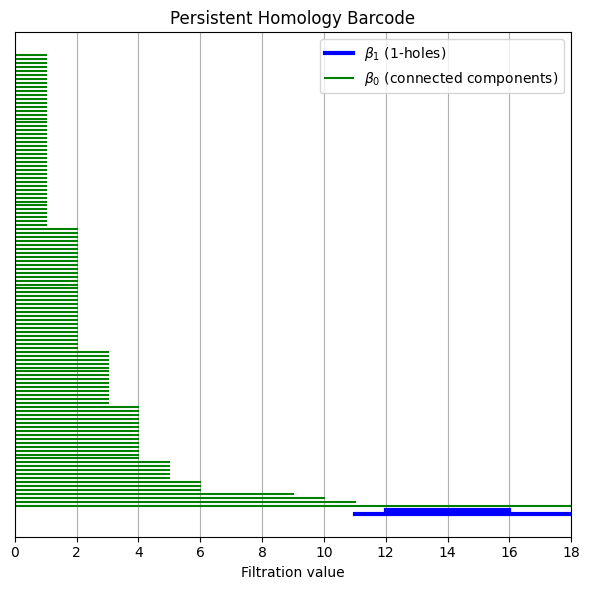

In [87]:
diag2 = persistence2  # Assuming you have this from GUDHI
plot_persistence_barcode(diag2, max_filtration_value=18,save_path="plots/barcode_sim128_hgt.svg")

<AxesSubplot:title={'center':'Persistence barcode'}>

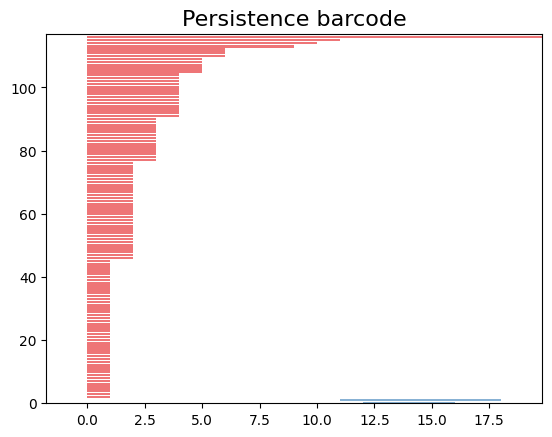

In [17]:
gd.plot_persistence_barcode(persistence2)

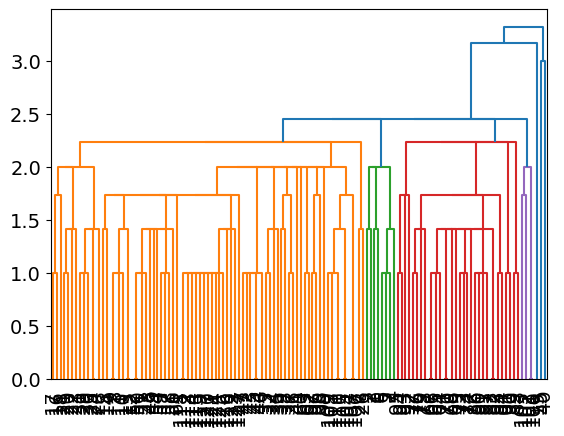

In [18]:
plot_dendrogram(population_2)

In [19]:
# genome_indices, genome_indices_2

[(1, (11.0, 18.0)),
 (1, (12.0, 16.0)),
 (0, (0.0, inf)),
 (0, (0.0, 11.0)),
 (0, (0.0, 10.0)),
 (0, (0.0, 9.0)),
 (0, (0.0, 6.0)),
 (0, (0.0, 6.0)),
 (0, (0.0, 6.0)),
 (0, (0.0, 5.0)),
 (0, (0.0, 5.0)),
 (0, (0.0, 5.0)),
 (0, (0.0, 5.0)),
 (0, (0.0, 5.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 4.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 2.0)),
 (0, (0.0, 2.0)),
 (0, (0.0, 2.0)),
 (0, (0.0, 2.0)),
 (0, (0.0, 2.0)),
 (0, (0.0, 2.0)),
 (0, (0.0, 2.0)),
 (0, (0.0, 2.0)),
 (0, (0.0, 2.0)),
 (0, (0.0, 2.0)),
 (0, (0.0, 2.0)),
 (0, (0.0, 2.0)),
 (0, (0.0, 2.0)),
 (0,

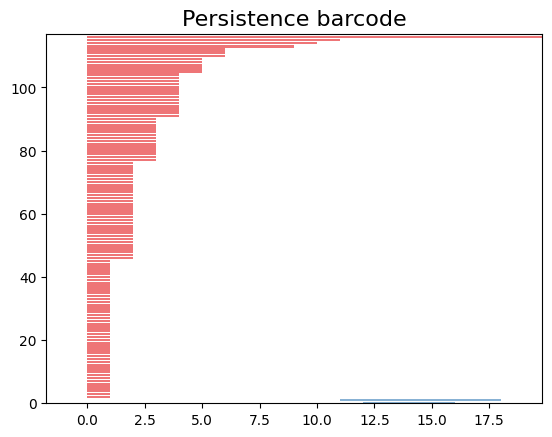

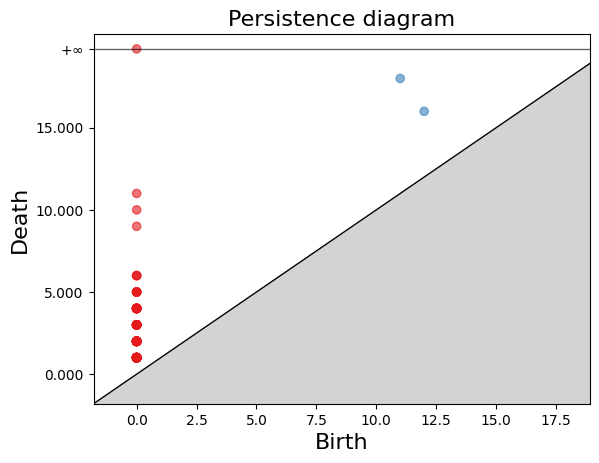

In [20]:
hamming_matrix_2 = calculate_hamming_matrix(population_2)
#hamming_matrix_2

# Print the normalized Hamming distance matrix
#print("Normalized Hamming Distance Matrix:")
#print(normalized_hamming_matrix_2)
persistence2, simplex_tree2 = create_complex(hamming_matrix_2)
gd.plot_persistence_barcode(persistence2)
gd.plot_persistence_diagram(persistence2)
persistence2


In [21]:
#visualize_simplicial_complex(simplex_tree2,101)

In [22]:
type(persistence2)

list

In [23]:
def calculate_persistence_and_average(input_list):
    # Filter tuples with a 1 in the first position
    filtered = [tuple for tuple in input_list if tuple[0] == 1]

    # Calculate persistence for each filtered tuple
    persistences = [abs(tuple[1][1] - tuple[1][0]) for tuple in filtered]

    # Calculate the average of these persistences
    average_persistence = sum(persistences) / len(persistences) if persistences else 0

    return filtered, persistences, average_persistence




In [24]:
# Example usage
list_example = [(1, (12.0, 17.0)), (1, (11.0, 13.0)), (0, (0.0, 1.0))]
filtered, persistences, average_persistence = calculate_persistence_and_average(list_example)

print("Filtered:", filtered)
print("Persistences:", persistences)
print("Average Persistence:", average_persistence)



Filtered: [(1, (12.0, 17.0)), (1, (11.0, 13.0))]
Persistences: [5.0, 2.0]
Average Persistence: 3.5


In [25]:
filtered, persistences, average_persistence = calculate_persistence_and_average(persistence2)
print("Filtered:", filtered)
print("Persistences:", persistences)
print("Average Persistence:", average_persistence)


Filtered: [(1, (11.0, 18.0)), (1, (12.0, 16.0))]
Persistences: [7.0, 4.0]
Average Persistence: 5.5


In [26]:
def analyze_population(population, num_groups, group_size, num_positions):
    # Modify genomes with the new num_groups parameter
    population_modified = modify_genomes(population, num_groups=num_groups, group_size=group_size, num_positions_to_change=num_positions)

    # Calculate the Hamming matrix
    hamming_matrix = calculate_hamming_matrix(population_modified)

    # Perform persistent homology
    persistence, simplex_tree = create_complex(hamming_matrix)

    # Calculate persistence and average
    filtered, persistences, average_persistence = calculate_persistence_and_average(persistence)

    # Return number of 1-holes and their persistences
    return len(filtered), persistences



### Ejemplos


In [27]:
def analyze_population2(population, num_groups, group_size, num_positions):
    # Modificar los genomas con el nuevo parámetro num_groups
    population_modified = modify_genomes(population, num_groups=num_groups, group_size=group_size, num_positions_to_change=num_positions)

    # Calcular la matriz de Hamming
    hamming_matrix = calculate_hamming_matrix(population_modified)

    # Realizar homología persistente
    persistence, simplex_tree = create_complex(hamming_matrix)

    # Calcular persistencia y promedio
    filtered, persistences, average_persistence = calculate_persistence_and_average(persistence)

    # Retornar número de 1-hoyos y sus persistencias
    return len(filtered), persistences, hamming_matrix, persistence


In [28]:
num_1_holes_29, persistences_29, hamming_29, persistence_29 = analyze_population2(population, 1,3, 29)
num_1_holes_60, persistences2, hamming_60, persistence_60= analyze_population2(population, 1,3, 60)

In [29]:
####esta comentado porque tada un poco ######
# import matplotlib.pyplot as plt

# # Assuming you have a range of values for num_positions_to_change
# num_positions_changes = range(1, 100)

# # Lists to store plot data
# num_1_holes_list = []
# average_persistences = []

# for num in num_positions_changes:
#     num_1_holes, persistences = analyze_population(population, 1,3, num)
#     num_1_holes_list.append(num_1_holes)
#     average_persistences.append(sum(persistences) / len(persistences) if persistences else 0)

# # Assuming num_positions_changes and average_persistences are defined
# # Create the scatter plot
# plt.scatter(num_positions_changes, average_persistences, c=average_persistences, cmap='cividis')
# plt.colorbar(label='Average Persistence').ax.tick_params(labelsize=12)  # Adjust colorbar label size
# plt.xlabel('Number of Positions Transfer', fontsize=16)  # Adjust x-axis label size
# plt.ylabel('Average Persistence', fontsize=16)  # Adjust y-axis label size
# plt.xticks(fontsize=16)  # Adjust x-axis tick label size
# plt.yticks(fontsize=16)  # Adjust y-axis tick label size
# #plt.title('Variation in 1-hole persistence', fontsize=14)  # Uncomment to add title with adjusted size

# # Save the plots
# plt.savefig("plots/numbers_positions.svg", dpi=600)
# plt.savefig("plots/numbers_positions.png", dpi=600)

# # Display the plot
# plt.show()


##Descomentar

In [30]:
# import matplotlib.pyplot as plt

# # Assuming you have a range of values for num_positions_to_change
# num_positions_changes = range(1, 100)

# # Lists to store plot data
# num_1_holes_list = []
# average_persistences = []

# for num in num_positions_changes:
#     num_1_holes, persistences = analyze_population(population, 4,3, num)
#     num_1_holes_list.append(num_1_holes)
#     average_persistences.append(sum(persistences) / len(persistences) if persistences else 0)

# # Assuming num_positions_changes and average_persistences are defined
# # Create the scatter plot
# plt.scatter(num_positions_changes, average_persistences, c=average_persistences, cmap='cividis')
# plt.colorbar(label='Average Persistence').ax.tick_params(labelsize=12)  # Adjust colorbar label size
# plt.xlabel('Number of Positions Changed', fontsize=16)  # Adjust x-axis label size
# plt.ylabel('Average Persistence', fontsize=16)  # Adjust y-axis label size
# plt.xticks(fontsize=16)  # Adjust x-axis tick label size
# plt.yticks(fontsize=16)  # Adjust y-axis tick label size
# #plt.title('Variation in 1-hole persistence', fontsize=14)  # Uncomment to add title with adjusted size

# # Save the plots
# # plt.savefig("plots/numbers_positions.svg", dpi=600)
# # plt.savefig("plots/numbers_positions.png", dpi=600)

# # Display the plot
# plt.show()


In [31]:
def plot_groups_vs_1_holes(population, max_num_groups, num_positions_to_change):
    num_groups_values = range(1, max_num_groups + 1)
    num_1_holes_list = []
    average_persistences = []

    for num_groups in num_groups_values:
        num_1_holes, persistences = analyze_population(population, num_groups, 3, num_positions_to_change)
        num_1_holes_list.append(num_1_holes)
        average_persistence = sum(persistences) / len(persistences) if persistences else 0
        average_persistences.append(average_persistence)

    # Crear la gráfica
    plt.figure(figsize=(6,6))
    plt.scatter(num_groups_values, num_1_holes_list, c=average_persistences, cmap='cividis')
    plt.xlabel('Number of Groups',fontsize=16)
    plt.ylabel('Number of 1-Holes',fontsize=16)
    plt.xticks(fontsize=16)  # Adjust x-axis tick label size
    plt.yticks(fontsize=16)  # Adjust y-axis tick label size
    colorbar = plt.colorbar(label='Average Persistence')
    colorbar.ax.tick_params(labelsize=16)
    colorbar.set_label('Average Persistence', fontsize=16)
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.savefig("plots/numbers_groups.svg",format='svg', dpi=600, bbox_inches='tight')
    plt.show()



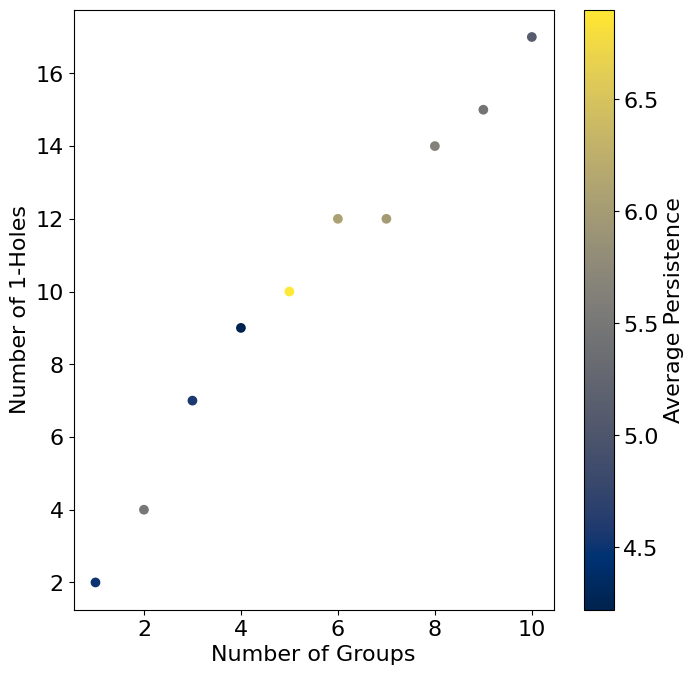

In [32]:
population
# Ejemplo de uso
plot_groups_vs_1_holes(population, max_num_groups=10, num_positions_to_change=60)

In [33]:
num_groups_values = range(1, 10 + 1)
num_1_holes_list = []
average_persistences = []
for num_groups in num_groups_values:
    num_1_holes, persistences = analyze_population(population, num_groups, 3, 60)
    num_1_holes_list.append(num_1_holes)
    average_persistence = sum(persistences) / len(persistences) if persistences else 0
    average_persistences.append(average_persistence)


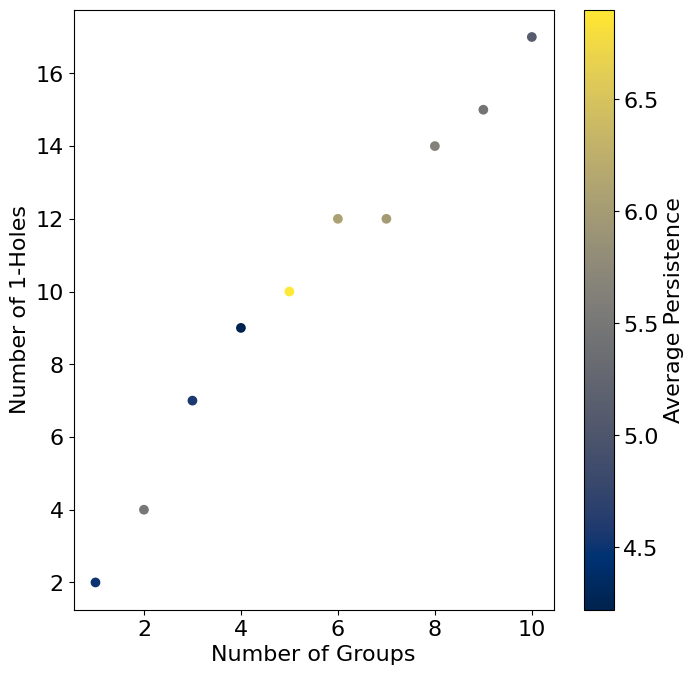

In [34]:

    # Crear la gráfica
plt.figure(figsize=(6,6))
plt.scatter(num_groups_values, num_1_holes_list, c=average_persistences, cmap='cividis')
plt.xlabel('Number of Groups',fontsize=16)
plt.ylabel('Number of 1-Holes',fontsize=16)
plt.xticks(fontsize=16)  # Adjust x-axis tick label size
plt.yticks(fontsize=16)  # Adjust y-axis tick label size
colorbar = plt.colorbar(label='Average Persistence')
colorbar.ax.tick_params(labelsize=16)
colorbar.set_label('Average Persistence', fontsize=16)
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.savefig("plots/numbers_groups.svg",format='svg', dpi=600, bbox_inches='tight')
plt.savefig("plots/numbers_groups.png",format='png', dpi=600, bbox_inches='tight')
plt.show()


In [35]:
# ###solo un procesador
# import numpy as np  # Asumimos que necesitamos NumPy para manejo de arrays

# # Definir los parámetros iniciales
# num_genes = 505
# mutation_probability = 1 / num_genes
# num_generations = 7
# num_offspring = 2
# percentage_ones = 0.25
# seeds_range = range(1, 11)  # Por ejemplo, de 1 a 10

# # Diccionario para almacenar los datos de todos los experimentos
# experiments_results = {}

# # Iterar sobre el rango de semillas
# for seed in seeds_range:
#     print(f"Procesando semilla {seed} de {len(seeds_range)}...")  # Informar cuál semilla se está procesando

#     # Suponiendo que create_population() y analyze_population() son funciones previamente definidas
#     population, population_genome_history = create_population(num_genes, mutation_probability, num_generations, num_offspring, percentage_ones, seed)
#     population = np.array(population)

#     # Listas para almacenar datos de cada semilla
#     num_1_holes_list = []
#     average_persistences = []

#     # Analizar la población y recolectar los datos para cada semilla
#     num_positions_changes = range(1, 100)
#     for num in num_positions_changes:
#         num_1_holes, persistences = analyze_population(population, 1, 3, num)
#         num_1_holes_list.append(num_1_holes)
#         average_persistences.append(sum(persistences) / len(persistences) if persistences else 0)

#     # Agregar el subdiccionario con los resultados del experimento actual al diccionario principal
#     experiments_results[seed] = {
#         'seed': seed,
#         'num_1_holes_list': num_1_holes_list,
#         'average_persistences': average_persistences
#     }

# # Ahora, experiments_results contiene los resultados de todos los experimentos indexados por semilla



In [36]:
import multiprocessing
from functools import partial

def process_seed(seed, num_genes, mutation_probability, num_generations, num_offspring, percentage_ones):
    print(f"Procesando semilla {seed}...")
    population, population_genome_history = create_population(num_genes, mutation_probability, num_generations, num_offspring, percentage_ones, seed)
    population = np.array(population)
    num_1_holes_list = []
    average_persistences = []
    num_positions_changes = range(1, 100)
    for num in num_positions_changes:
        num_1_holes, persistences = analyze_population(population, 1, 3, num)
        num_1_holes_list.append(num_1_holes)
        average_persistences.append(sum(persistences) / len(persistences) if persistences else 0)
    return num_1_holes_list, average_persistences, population




In [37]:
num_genes = 505
mutation_probability = 1 / num_genes
num_generations = 7
num_offspring = 2
percentage_ones = 0.25
seeds_range = range(40, 42)  # Por ejemplo, de 1 a 10
for seed in seeds_range:
    num_1_holes_list, average_persistences, population = process_seed(seed, num_genes=num_genes, mutation_probability=mutation_probability, num_generations=num_generations, num_offspring=num_offspring, percentage_ones=percentage_ones)
    
    
    # Agregar el subdiccionario con los resultados del experimento actual al diccionario principal
    experiments_results[seed] = {
        'seed': seed,
        'num_1_holes_list': num_1_holes_list,
        'average_persistences': average_persistences,
        'population':population
    }


Procesando semilla 40...
Generation 1: 2 genomes
Generation 2: 4 genomes
Generation 3: 8 genomes
Generation 4: 16 genomes
Generation 5: 32 genomes
Generation 6: 64 genomes
Generation 7: 128 genomes


NameError: name 'experiments_results' is not defined

### Transferencia entre grupos


In [88]:
# Example usage
num_genes = 505
mutation_probability = 1 / num_genes
num_generations = 3
num_offspring = 2
percentage_ones = 0.25

population_esc, population_esc_genome_history = create_population(num_genes, mutation_probability, num_generations, num_offspring, percentage_ones,42)

Generation 1: 2 genomes
Generation 2: 4 genomes
Generation 3: 8 genomes


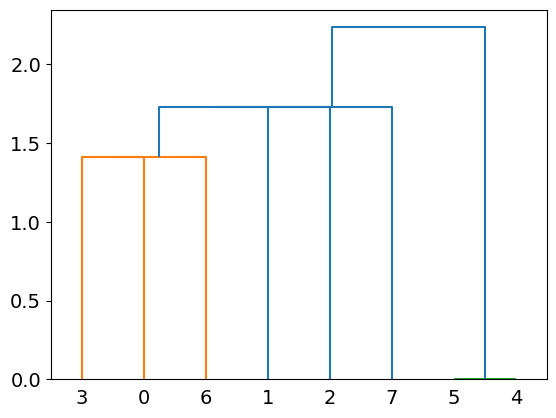

In [89]:
# Calculate the Hamming distance matrix
population_esc = np.array(population_esc)
hamming_distance_matrix_esc= calculate_hamming_matrix(population_esc)
# population_2 now has the changes applied to two randomly selected genomes
plot_dendrogram(population_esc)


In [90]:
import numpy as np

# Asumiendo que population_esc es tu arreglo de NumPy
np.save('population_esc.npy', population_esc)


(array([-1. ,  0. ,  1. ,  2. ,  3. ,  4. ,  5. ,  5.5]),
 [Text(0, -1.0, '-1.000'),
  Text(0, 0.0, '0.000'),
  Text(0, 1.0, '1.000'),
  Text(0, 2.0, '2.000'),
  Text(0, 3.0, '3.000'),
  Text(0, 4.0, '4.000'),
  Text(0, 5.0, '5.000'),
  Text(0, 5.5, '$+\\infty$')])

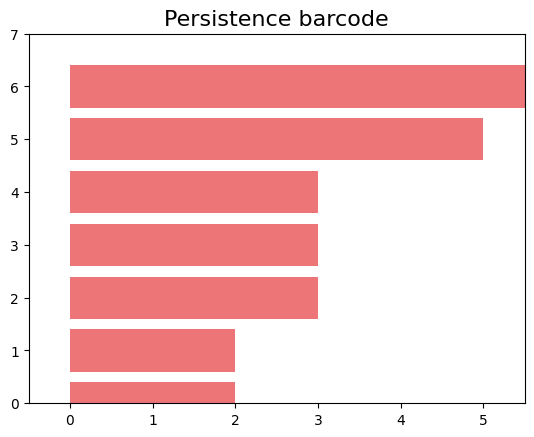

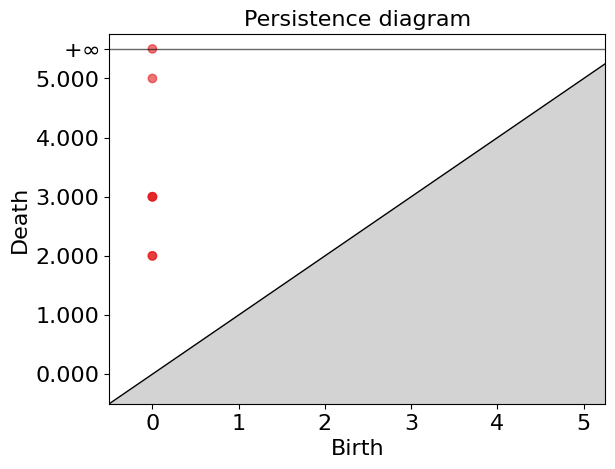

In [91]:


# Create a Vietoris-Rips complex from the distance matrix, and compute persistent homology.
persistence_esc, simplex_tree_esc = create_complex(hamming_distance_matrix_esc)
gd.plot_persistence_barcode(persistence_esc)
gd.plot_persistence_diagram(persistence_esc)
plt.xticks(fontsize=16)  # Adjust x-axis tick label size
plt.yticks(fontsize=16)  # Adjust y-axis tick label size



In [92]:
population_esc.shape[1]//32


15

In [ ]:
#np.save('population_esc_hgt.npy', population_esc_hgt)

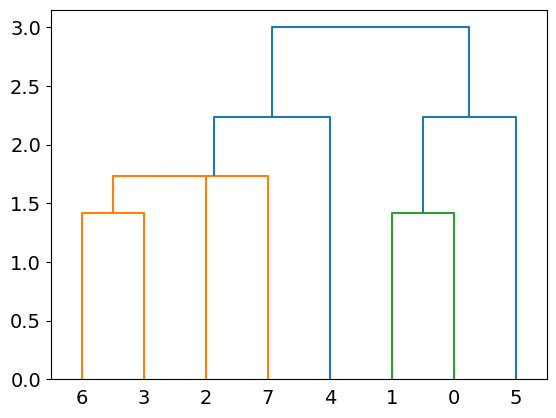

[(1, (11.0, 14.0)),
 (0, (0.0, inf)),
 (0, (0.0, 9.0)),
 (0, (0.0, 5.0)),
 (0, (0.0, 5.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 2.0)),
 (0, (0.0, 2.0))]

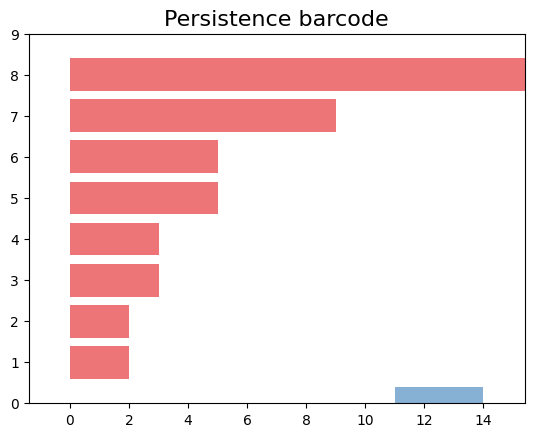

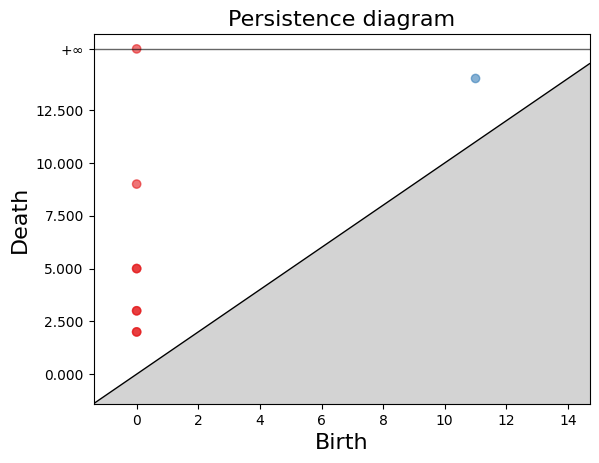

In [93]:
population_esc_hgt=modify_genomes(population_esc, num_groups=1, group_size=3, num_positions_to_change=population_esc.shape[1]//32)
plot_dendrogram(population_esc_hgt)
hamming_matrix_esc_hgt = calculate_hamming_matrix(population_esc_hgt)
#hamming_matrix_2

# Print the normalized Hamming distance matrix
#print("Normalized Hamming Distance Matrix:")
#print(normalized_hamming_matrix_2)
persistence_esc_hgt, simplex_tree_esc_hgt = create_complex(hamming_matrix_esc_hgt)
gd.plot_persistence_barcode(persistence_esc_hgt)
gd.plot_persistence_diagram(persistence_esc_hgt)
persistence_esc_hgt

In [124]:
# Initial parameters
num_genes = 505
mutation_probability = 1 / num_genes
num_generations = 3
num_offspring = 2
percentage_ones = 0.25

population_kle, population_kle_genome_history = create_population(num_genes, mutation_probability, num_generations, num_offspring, percentage_ones,92)

Generation 1: 2 genomes
Generation 2: 4 genomes
Generation 3: 8 genomes


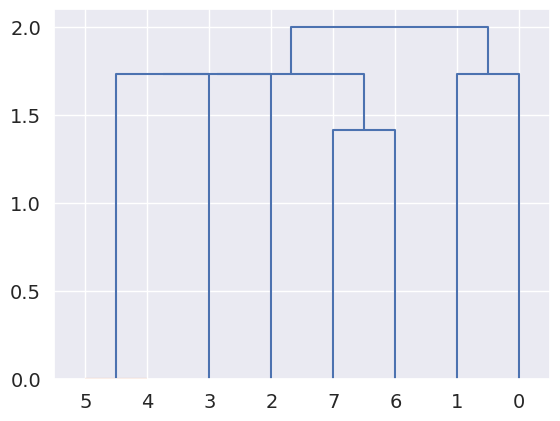

In [125]:
# Calculate the Hamming distance matrix
population_kle = np.array(population_kle)
hamming_distance_matrix_kle= calculate_hamming_matrix(population_kle)
# population_2 now has the changes applied to two randomly selected genomes
plot_dendrogram(population_kle)

(array([-1. ,  0. ,  1. ,  2. ,  3. ,  4. ,  4.4]),
 [Text(0, -1.0, '-1.000'),
  Text(0, 0.0, '0.000'),
  Text(0, 1.0, '1.000'),
  Text(0, 2.0, '2.000'),
  Text(0, 3.0, '3.000'),
  Text(0, 4.0, '4.000'),
  Text(0, 4.4, '$+\\infty$')])

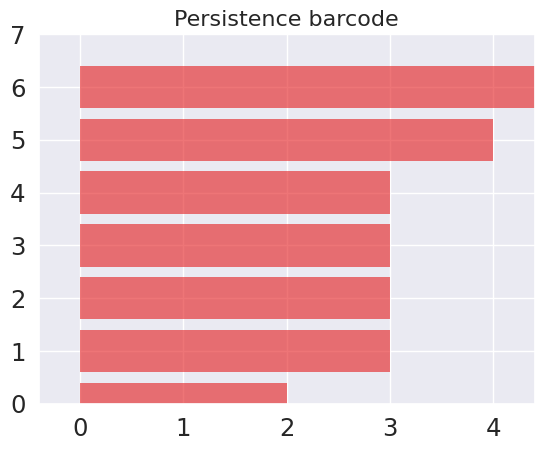

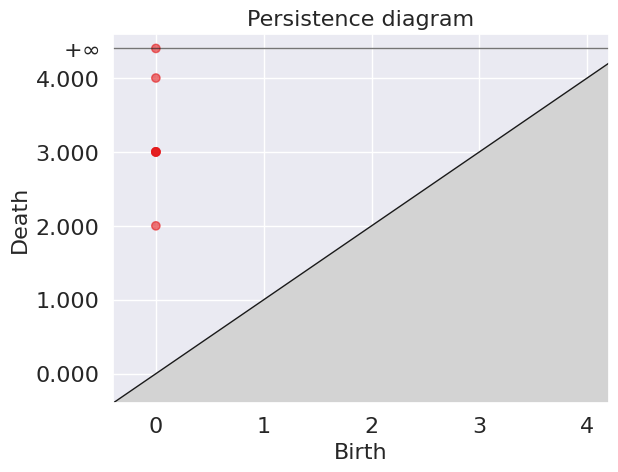

In [126]:
# Create a Vietoris-Rips complex from the distance matrix, and compute persistent homology.
persistence_kle, simplex_tree_kle = create_complex(hamming_distance_matrix_kle)
gd.plot_persistence_barcode(persistence_kle)
gd.plot_persistence_diagram(persistence_kle)
plt.xticks(fontsize=16)  # Adjust x-axis tick label size
plt.yticks(fontsize=16)  # Adjust y-axis tick label size


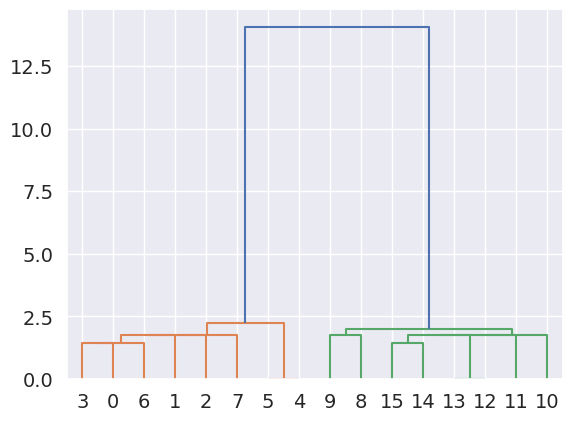

In [127]:
merged_population = np.vstack((population_esc, population_kle))
hamming_distance_matrix_merg= calculate_hamming_matrix(merged_population)
# population_2 now has the changes applied to two randomly selected genomes
plot_dendrogram(merged_population)


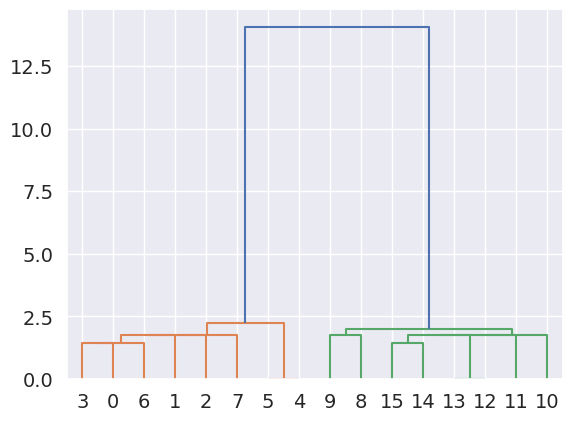

In [128]:
merged_population = np.vstack((population_esc, population_kle))
hamming_distance_matrix_merg= calculate_hamming_matrix(merged_population)
# population_2 now has the changes applied to two randomly selected genomes
plot_dendrogram(merged_population,path="plots/den_AB.svg")

In [ ]:
# # Create a Vietoris-Rips complex from the distance matrix, and compute persistent homology.
# persistence_merg, simplex_tree_merg = create_complex(hamming_distance_matrix_merg)
# gd.plot_persistence_barcode(persistence_merg)
# gd.plot_persistence_diagram(persistence_merg)


In [ ]:
len(merged_population)

In [129]:
def modify_and_merge_populations(population1, population2, num_positions_to_change):
    np.random.seed(100)  # Set a seed for reproducibility, you can change it as needed

    # Create copies of the populations to avoid modifying the originals
    modified_population1 = population1.copy()
    modified_population2 = population2.copy()

    # Randomly select two genomes from the first population
    genome_indices_1 = np.random.choice(population1.shape[0], 2, replace=False)

    # Randomly select one genome from the second population
    genome_index_2 = np.random.choice(population2.shape[0], 1, replace=False)[0]

    # Choose contiguous positions to change
    start_position = np.random.choice(population1.shape[1] - num_positions_to_change)
    positions_to_change = np.arange(start_position, start_position + num_positions_to_change)

    # Swap the selected positions between the genomes
    for pos in positions_to_change:
        temp = modified_population1[genome_indices_1[0], pos]
        modified_population1[genome_indices_1[0], pos] = modified_population2[genome_index_2, pos]
        modified_population2[genome_index_2, pos] = temp

    # Merge the two modified populations
    merged_population = np.vstack((modified_population1, modified_population2))
    print(genome_indices_1,genome_index_2)

    #return merged_population, positions_to_change,genome_indices_1
    return merged_population




In [111]:
a=modify_and_merge_populations(population_esc, population_kle, num_positions_to_change=50)
a

[1 4] 0


array([[0, 1, 0, ..., 0, 1, 0],
       [0, 1, 0, ..., 0, 1, 0],
       [0, 1, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 1, ..., 1, 0, 0],
       [0, 0, 1, ..., 1, 0, 0],
       [0, 0, 1, ..., 1, 0, 0]])

In [ ]:
a[1]

[1 4] 0


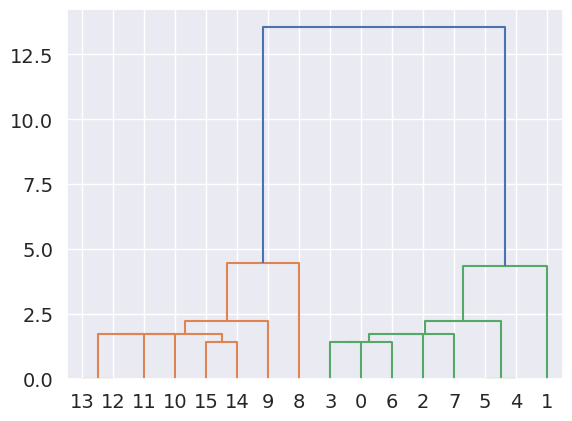

In [130]:
# Example usage
# population1 and population2 should be defined or loaded before using this function
merged_population_hgt = modify_and_merge_populations(population_esc, population_kle, num_positions_to_change=50)
hamming_distance_matrix_hgt= calculate_hamming_matrix(merged_population_hgt)
# population_2 now has the changes applied to two randomly selected genomes
plot_dendrogram(merged_population_hgt,path="plots/den_AB_THG.svg")


(array([-50. ,   0. ,  50. , 100. , 150. , 200. , 217.8]),
 [Text(0, -50.0, '-50.000'),
  Text(0, 0.0, '0.000'),
  Text(0, 50.0, '50.000'),
  Text(0, 100.0, '100.000'),
  Text(0, 150.0, '150.000'),
  Text(0, 200.0, '200.000'),
  Text(0, 217.8, '$+\\infty$')])

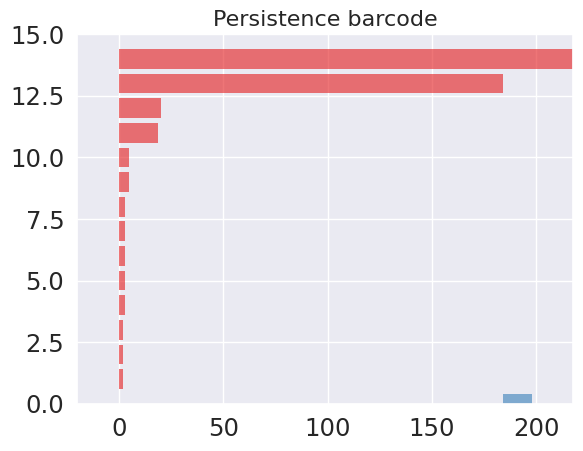

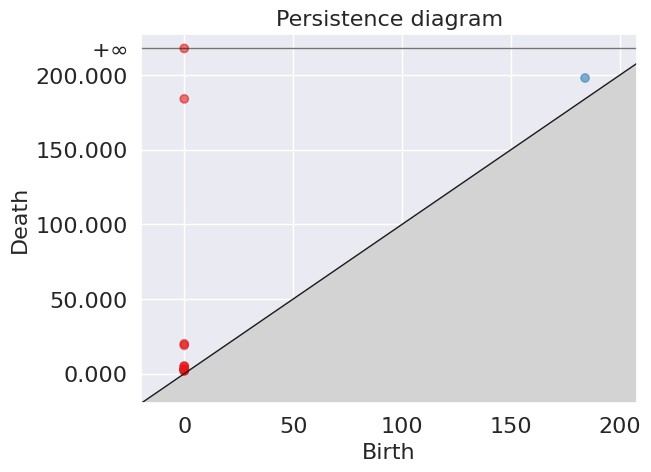

In [131]:
# Create a Vietoris-Rips complex from the distance matrix, and compute persistent homology.
persistence_merg, simplex_tree_merg = create_complex(hamming_distance_matrix_hgt)
gd.plot_persistence_barcode(persistence_merg)
gd.plot_persistence_diagram(persistence_merg)
plt.xticks(fontsize=16)  # Adjust x-axis tick label size
plt.yticks(fontsize=16)  # Adjust y-axis tick label size


In [132]:
persistence_merg

[(1, (184.0, 198.0)),
 (0, (0.0, inf)),
 (0, (0.0, 184.0)),
 (0, (0.0, 20.0)),
 (0, (0.0, 19.0)),
 (0, (0.0, 5.0)),
 (0, (0.0, 5.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 3.0)),
 (0, (0.0, 2.0)),
 (0, (0.0, 2.0)),
 (0, (0.0, 2.0))]

<Figure size 1000x1000 with 0 Axes>

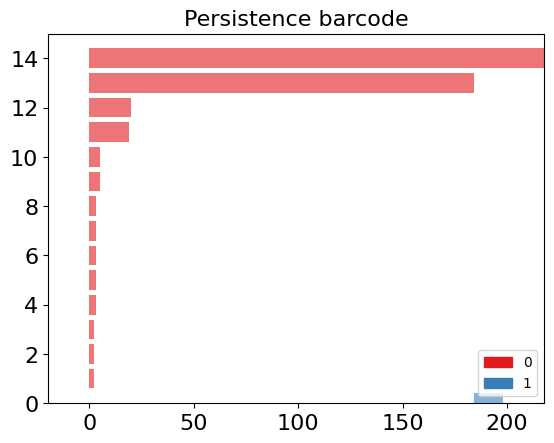

In [103]:


# Ajustar el tamaño del gráfico
plt.figure(figsize=(10, 10))  # Puedes ajustar estos números según tus necesidades
# Ajustar el layout
plt.tight_layout()
gd.plot_persistence_barcode(persistence_merg,legend=True)
plt.xticks(fontsize=16)  # Ajusta el tamaño según sea necesario
plt.yticks(fontsize=16)
plt.savefig("plots/barcode_sim_A_B.svg", dpi=600)
#plt.savefig("plots/barcode_sim_A_B.png", dpi=600)

In [ ]:
visualize_simplicial_complex(simplex_tree_merg,184,save_filename="plots/sim_simplicial_184.svg")

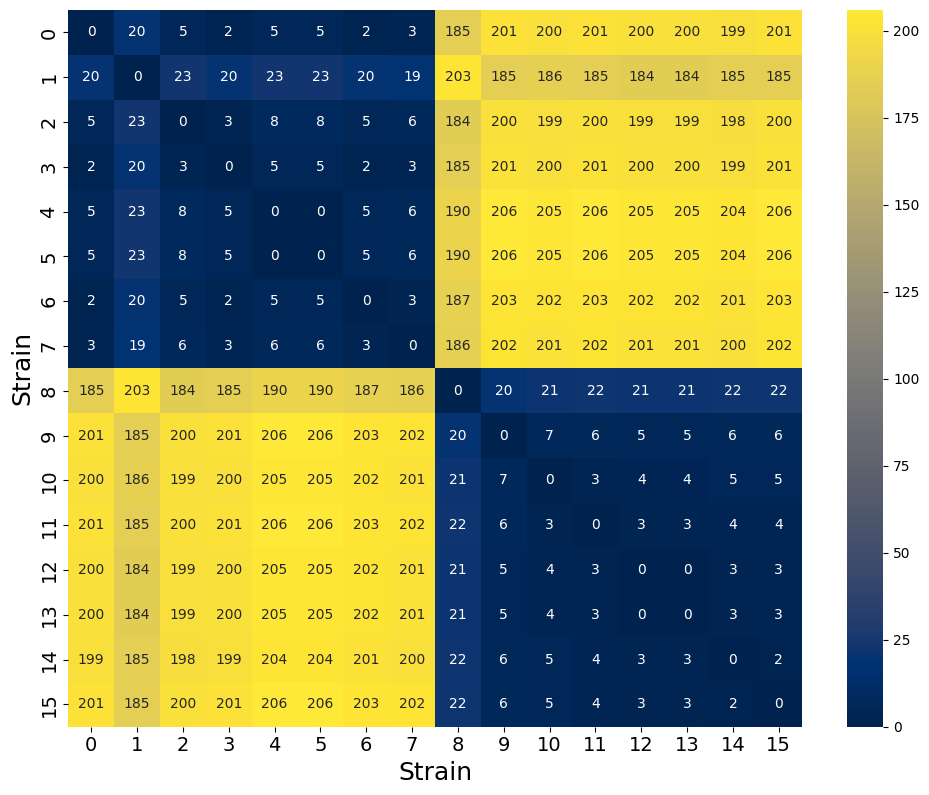

In [104]:
# Ajustar el tamaño del gráfico
plt.figure(figsize=(10, 8))  # Puedes ajustar estos números según tus necesidades

# Crear el heatmap
sns.heatmap(hamming_distance_matrix_hgt, annot=True, cmap='cividis',  fmt='.0f')

# Añadir títulos y etiquetas si es necesario
#plt.title('Heatmap for hamming matrix')
plt.xlabel('Strain',fontsize=18)
plt.ylabel('Strain',fontsize=18)


# Ajustar el layout
plt.tight_layout()

# Guardar el gráfico
# plt.savefig("plots/heatmap_hamming.svg", dpi=600)
# plt.savefig("plots/heatmap_hamming.png", dpi=600)
# Aumentar el tamaño de las etiquetas de los ejes
plt.xticks(fontsize=14)  # Ajusta el tamaño según sea necesario
plt.yticks(fontsize=14)
sns.set(font_scale=1.6)
# Mostrar el gráfico
plt.show()

In [ ]:
persistence_merg

In [ ]:
merged_population_hgt[:,334:433]
hamming_distance_matrix_selec= calculate_hamming_matrix(merged_population)

In [ ]:
def plot_dendrogram2(data, path=None):
    """Plot a dendrogram from the data and optionally save it to a file."""
    linked = linkage(data, 'single')
    dendrogram(linked, orientation='top', distance_sort='descending')
    
    # Ajustar el tamaño de la fuente para los ejes
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

    # Ajustar el grosor de las líneas del dendrograma
    # plt.gca().spines.values() # Este comando no ajusta el grosor, solo obtiene los ejes

    # Guardar la figura si se proporciona una ruta
    if path:
        plt.savefig(path, bbox_inches='tight')

    plt.show()

In [ ]:
#Example
# Example usage
num_genes = 505
mutation_probability = 1 / num_genes
num_generations = 5
num_offspring = 2
percentage_ones = 0.25

population_temp, population_genome_history_temp = create_population(num_genes, mutation_probability, num_generations, num_offspring, percentage_ones,42)


In [ ]:
# Calculate the Hamming distance matrix
population_temp = np.array(population_temp)
hamming_distance_matrix_temp = calculate_hamming_matrix(population_temp)
# population now has the changes applied to two randomly selected genomes
plot_dendrogram2(population_temp,path="dendo.png")

In [ ]:
population_temp